In [6]:
import trimesh
import trimesh.transformations as TF
from trimesh.proximity import closest_point
import torch
import numpy as np
import random
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from scipy import spatial
import os
import meshlabxml as mlx

In [3]:
import Render
Render.extIOR, Render.intIOR = 1.15, 1.0
# Render.extIOR, Render.intIOR = 1.5, 1.0
res=512
Float = torch.float64
device='cuda'
Render.res = res
Render.device = device
Render.Float = Float

In [ ]:

kitten = Render.Scene("/root/workspace/data/kitten.obj")
# kitten = Render.Scene("/root/workspace/data/kitten_vh_sim.ply")
kitten.set_camera((60,60), 1.3, center=(0,0,0), angles=None)
R,K = kitten.camera_RK()
origin, ray_dir = kitten.generate_ray()

# silhouette_edge = kitten.silhouette_edge(origin[0])
# index, output = kitten.primary_visibility(silhouette_edge, R, K, origin[0])
# image = torch.zeros((res,res))
# image[index[:,0],index[:,1]]=1
# Render.torch2pil(image)

target_mask = kitten.mask(origin, ray_dir)
# Render.torch2pil(target_mask)

# M = target_mask.view((res,res,1)).cpu().numpy()
# M = M.astype(np.uint8)

# dist= cv2.distanceTransform(M, cv2.DIST_L2, 0) - cv2.distanceTransform(1-M, cv2.DIST_L2, 0)
# img = dist.clip(-30,30)
# img = 255 * (img-img.min()) / (img.max()-img.min())
# Image.fromarray(img.astype(np.uint8))

# soft_mask = (dist.clip(-30,30) + 30) / 60
# soft_mask = torch.tensor(soft_mask, dtype=Float, device=device)



In [ ]:
new_vert = kitten.vertices + torch.tensor([0.2,0.2,-0.2], device=device)
kitten.update_verticex(new_vert)
# Render.torch2pil(kitten.mask(origin, ray_dir))

vertices = kitten.vertices
parameter = torch.zeros(3,  device=device, requires_grad=True)
opt = torch.optim.Adam([parameter], lr=.02)
# opt = torch.optim.SGD([parameter], lr=.0005)
gif = []
for i in range(99):

    mask = kitten.mask(origin, ray_dir)
    # gif.append(Render.torch2pil(mask))
    gif.append(Render.torch2pil((0.8*mask+0.5*target_mask).clamp(0,1)))
    error = (target_mask - mask).abs().mean()
    print('Iteration %03i: error=%g' % (i, error), end='\r')

    opt.zero_grad()
    new_vert = vertices + parameter
    kitten.update_verticex(new_vert)
    silhouette_edge = kitten.silhouette_edge(origin[0])
    index, output = kitten.primary_visibility(silhouette_edge, R, K, origin[0])
    loss = (target_mask.view((res,res))[index[:,0],index[:,1]] - output).abs().mean()
    # loss = (soft_mask[index[:,0],index[:,1]] - output).abs().mean()
    loss.backward()
    opt.step()


In [ ]:
%%capture
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
fig = plt.figure()
im = plt.imshow(gif[0], animated=True)
def update_fig(i):
    im.set_array(gif[i])
    return im,
anim = animation.FuncAnimation(fig, update_fig, frames=len(gif), interval=50, blit=True)


In [ ]:
HTML(anim.to_jshtml())

In [ ]:
def render_target(scene:Render.Scene, deg):
    #俯视
    M=TF.rotation_matrix(-np.pi/180*0, [1,0,0])
    angle = TF.euler_from_matrix(TF.rotation_matrix(np.pi/180*deg, [0,1,0]) @ M)
    # scene.set_camera(fov=(60,60), distance = 1.0, center=(0,0.0,0), angles=angle)
    scene.set_camera(fov=(60,60), distance = 1.1, center=(0,0.0,0), angles=angle)
    R, K = scene.camera_RK()
    origin, ray_dir = scene.generate_ray()
    mask = scene.mask(origin, ray_dir)
    return mask, origin, ray_dir, R, K

Target = Render.Scene("/root/workspace/data/kitten.obj")
Views = []
for deg in range(0,360,5):
    Views.append(render_target(Target, deg))


In [ ]:
Render.torch2pil(Views[2][0])

In [ ]:

kitten_sm = Render.Scene("/root/workspace/data/kitten_oversm.ply")
sm_vertices = kitten_sm.vertices
sm_normals = torch.tensor(kitten_sm.mesh.vertex_normals, dtype=Float, device=device)

parameter = torch.zeros(sm_vertices.shape, dtype=Float, requires_grad=True, device=device)
# parameter = torch.zeros((sm_vertices.shape[0],1), dtype=Float, requires_grad=True, device=device)
# parameter.register_hook(kitten_sm.laplac_hook)
# parameter.register_hook(kitten_sm.laplac_normal_hook)
# kitten_sm.hook_normal = sm_normals
opt = torch.optim.Adam([parameter], lr=.002)
# lr = 0.0001
# opt = torch.optim.SGD([parameter], lr=lr)
# kitten_sm.hook_w = 0.5 * 10000

init_laplac = sm_vertices - kitten_sm.weightM.mm(sm_vertices) 
init_laplac_norm = init_laplac * sm_normals

vertices = sm_vertices + parameter
kitten_sm.update_verticex(vertices)

for it in range(399):
    # Zero out gradients before each iteration
    opt.zero_grad()

    loss = 0
    # for view in Views:
    for _ in range(1):
        V_index = random.randint(0, len(Views)-1)
        target_mask, origin, ray_dir, R, K = Views[V_index]
        # target_mask, origin, ray_dir, R, K = view
        silhouette_edge = kitten_sm.silhouette_edge(origin[0])
        index, output = kitten_sm.primary_visibility(silhouette_edge, R, K, origin[0], detach_depth=True)
        loss += (target_mask.view((res,res))[index[:,0],index[:,1]] - output).abs().sum()
        # loss += (soft_mask[index[:,0],index[:,1]] - output).abs().sum()
    # Optimizer: take a gradient step
    loss /= 1
    loss.backward()
    opt.step()

    # vertices_detach = sm_vertices + parameter.detach()
    # laplac = vertices_detach - kitten_sm.weightM.mm(vertices_detach) 
    # laplac_norm = laplac * sm_normals
    # # print(laplac_norm.max())
    # mask_shrink = (laplac_norm>0) * (laplac_norm<0.01)
    # # mask_shrink = (laplac_norm>0)
    # laplac[mask_shrink] = 0
    # sm_vertices -= 0.1*laplac

    # taubin smooth
    for _ in range(1):
        vertices_detach = sm_vertices + parameter.detach()
        laplac = vertices_detach - kitten_sm.weightM.mm(vertices_detach) 
        sm_vertices -= 0.5*laplac
        vertices_detach = sm_vertices + parameter.detach()
        laplac = vertices_detach - kitten_sm.weightM.mm(vertices_detach) 
        sm_vertices += 0.5*laplac


    vertices = sm_vertices + parameter
    kitten_sm.update_verticex(vertices)

    # print('Iteration %03i: error=%g' % (it, loss), end='\r')
    print('Iteration %03i: error=%g laplac=%g' % (it, loss, torch.norm(laplac, dim=1).mean().item()), end='\r')


In [ ]:
_=kitten_sm.mesh.export("kitten_edge.ply")

In [ ]:
sm_vertices.max()

In [24]:
# Render.extIOR, Render.intIOR = 1.15, 1.0
Render.extIOR, Render.intIOR = 1.5, 1.0

def render_target(scene:Render.Scene, deg):
    #俯视
    M=TF.rotation_matrix(-np.pi/180*0, [1,0,0])
    angle = TF.euler_from_matrix(TF.rotation_matrix(np.pi/180*deg, [0,1,0]) @ M)
    # scene.set_camera(fov=(60,60), distance = 1.0, center=(0,0.0,0), angles=angle)
    # scene.set_camera(fov=(60,60), distance = 1.1, center=(0,0.0,0), angles=angle)
    scene.set_camera(fov=(60,60), distance = 1.3, center=(0,0.0,0), angles=angle)
    R, K = scene.camera_RK()
    origin, ray_dir = scene.generate_ray()
    target, twice_mask = scene.render_transparent(origin, ray_dir)
    mask = scene.mask(origin, ray_dir)

    M = mask.view((res,res,1)).cpu().numpy()
    M = M.astype(np.uint8)
    bound = 1
    dist= (cv2.distanceTransform(M, cv2.DIST_L2, 0)-1).clip(0,bound)\
     - (cv2.distanceTransform(1-M, cv2.DIST_L2, 0)-1).clip(0,bound)
    soft_mask = (dist + bound) / (2*bound)
    soft_mask = torch.tensor(soft_mask, dtype=Float, device=device)

    return target, twice_mask, soft_mask, origin, ray_dir, R, K

# Target = Render.Scene("/root/workspace/data/kitten.obj")
Target = Render.Scene("/root/workspace/data/bunny.ply")
Views = []
for deg in range(-90,90,15):
    Views.append(render_target(Target, deg))
# # for deg in [-30,-15,0,15,30]:
for deg in range(-90,90,15):
    Views.append(render_target(Target, deg+180))


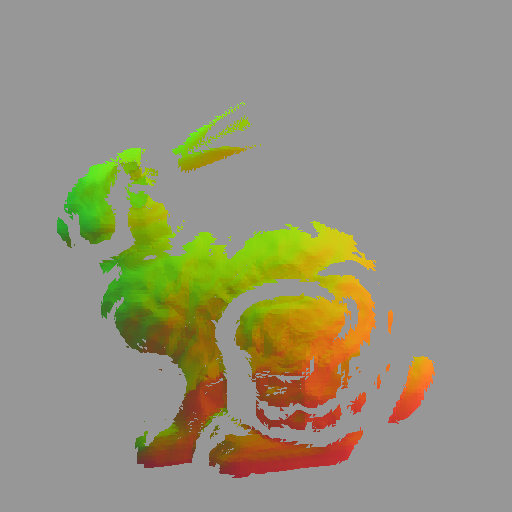

In [27]:
Render.torch2pil(Views[6][0])

In [ ]:

target, twice_mask, mask, origin, ray_dir, R, K = Views[1]
silhouette_edge = Target.silhouette_edge(origin[0])
index, output = Target.primary_visibility(silhouette_edge, R, K, origin[0], detach_depth=True)
sil = mask.view((res,res))[index[:,0],index[:,1]]
sil[sil<1]

In [102]:

# kitten_vh = Render.Scene("/root/workspace/DR/kitten_remesh.ply")
# kitten_vh = Render.Scene("/root/workspace/data/kitten_vh_sim.ply")
# kitten_vh = Render.Scene("/root/workspace/data/kitten_vh_sub.ply")
# kitten_vh = Render.Scene("/root/workspace/data/bunny_vh_sim.ply")
kitten_vh = Render.Scene("/root/workspace/data/bunny_vh_sub.ply")
# kitten_vh = Render.Scene("/root/workspace/DR/bunny_optim_remesh.ply")
vh_vertices = kitten_vh.vertices
vh_normals = torch.tensor(kitten_vh.mesh.vertex_normals, dtype=Float, device=device)
vh_faces = torch.tensor(kitten_vh.mesh.faces, device=device)
parameter = torch.zeros(vh_vertices.shape, dtype=Float, requires_grad=True, device=device)
def limit_hook(grad):
    grad[grad>1]=1
    grad[grad<-1]=-1
    return grad
parameter.register_hook(limit_hook)
# opt = torch.optim.Adam([parameter], lr=.0003)
# opt = torch.optim.Adam([parameter], lr=.0003)
# opt = torch.optim.Adam([parameter], lr=.001)
# opt = torch.optim.SGD([parameter], lr=.001, momentum = 0.9, nesterov =True)
opt = torch.optim.SGD([parameter], lr=.001, momentum = 0.9, nesterov =True)

# e1 = kitten_vh.mesh.vertices[kitten_vh.mesh.edges[:,0]]
# e2 = kitten_vh.mesh.vertices[kitten_vh.mesh.edges[:,1]]
# mean_len = np.linalg.norm(e1-e2, axis=1).mean()

dist = []
_=Target.mesh.export("/dev/shm/DR/target.ply")

In [104]:
mean_len

0.021187647267457914

In [103]:
# opt = torch.optim.SGD([parameter], lr=.0001, momentum = 0.9, nesterov =True)

def area_var(vertices):
    v0=vertices[vh_faces[:,0]]
    v1=vertices[vh_faces[:,1]]
    v2=vertices[vh_faces[:,2]]
    edge1 = v1-v0
    edge2 = v2-v0
    area =torch.cross(edge1,edge2).norm(dim=1)
    area_ave = area.mean().detach()
    area_var = ((area-area_ave)/area_ave).pow(2).mean()
    return area_var
def mean_hausd(mesh):
    # closest, distance, triangle_id = closest_point(Target.mesh, vertices)
    # distance = distance*9.7*2
    # return distance.mean()
    tmppath = "/dev/shm/DR/temp.ply"
    mesh.export(tmppath)
    logpath = "/dev/shm/DR/hausd_log"
    os.system('rm '+logpath)
    cmd = "DISPLAY=:1 meshlabserver -i " + tmppath + " /dev/shm/DR/target.ply -s /root/workspace/data/hausd.mlx -l " + logpath
    assert (os.system(cmd)==0)
    dist = mlx.compute.parse_hausdorff(logpath)['mean_distance']
    return dist

for it in range(3999):
# for it in range(999):


    V_index = random.randint(0, len(Views)-1)
    # V_index = 2
    target, twice_mask, mask, origin, ray_dir, R, K = Views[V_index]
    # Zero out gradients before each iteration
    opt.zero_grad()

    # vertices = vh_vertices + parameter * vh_normals
    vertices = vh_vertices + parameter
    kitten_vh.update_verticex(vertices)

    render_img, render_twice_mask = kitten_vh.render_transparent(origin, ray_dir)
    twice_mask = (twice_mask * render_twice_mask)
    # loss = 1e3*(render_img[twice_mask]-target[twice_mask]).pow(2).mean()
    loss = 1e2*(render_img[twice_mask]-target[twice_mask]).pow(2).mean()

    silhouette_edge = kitten_vh.silhouette_edge(origin[0])
    index, output = kitten_vh.primary_visibility(silhouette_edge, R, K, origin[0], detach_depth=True)
    vh_loss = 1e2 * (mask.view((res,res))[index[:,0],index[:,1]] - output).abs().mean()

    # rough = 0 * parameter.abs().mean()

    laplac = vertices - kitten_vh.weightM.mm(vertices) 
    # sm_loss = 5e1*torch.norm(laplac/0.02, dim=1).pow(2).mean()    
    sm_loss = 2e1*torch.norm(laplac/0.02, dim=1).pow(2).mean()    
    # sm_loss = torch.norm(laplac, dim=1).mean()
    # area_loss = 2*area_var(vertices)
    area_loss = 0*area_var(vertices)

    (loss+sm_loss+vh_loss+area_loss).backward()

    if it % 200 == 0:
        # dist.append(mean_hausd(vertices.detach().cpu().numpy()))
        dist.append(mean_hausd(kitten_vh.mesh))

    print('Iteration %03i: error=%g sm=%g vh=%g grad=%g' % (it, loss, sm_loss, vh_loss, parameter.grad.abs().max()), end='\r')
    # Optimizer: take a gradient step
    opt.step()

    # vertices_detach = vh_vertices + parameter.detach()
    # laplac = vertices_detach - kitten_vh.weightM.mm(vertices_detach) 
    # vh_vertices -= 0.3*laplac
    # vertices_detach = vh_vertices + parameter.detach()
    # laplac = vertices_detach - kitten_vh.weightM.mm(vertices_detach) 
    # vh_vertices += 0.3*laplac


    # imageio.imsave("result/disp_{}.png".format(it), parameter.detach().cpu())

# _=mesh_vh.export("kitten_optim.ply")


Iteration 3998: error=0.464939 sm=0.284034 vh=40.0206 grad=1

In [101]:
# _=kitten_vh.mesh.export("kitten_optim2.ply")
_=kitten_vh.mesh.export("bunny_debug.ply")

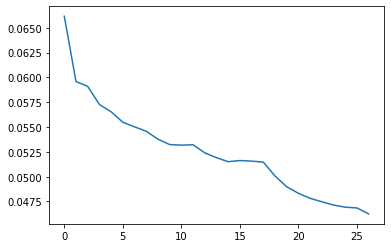

In [66]:
plt.plot(range(len(dist)),dist)
#ior 1.5

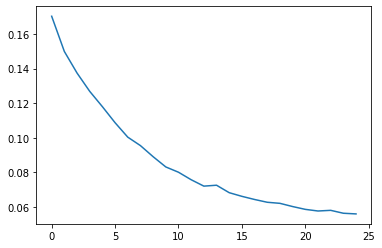

In [100]:
plt.plot(range(len(dist)),dist)
#ior 1.5

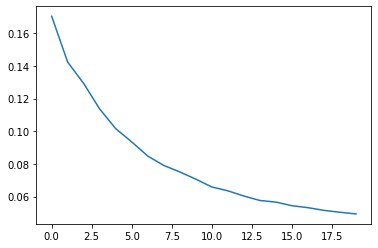

In [23]:
plt.plot(range(len(dist)),dist)
#area loss 2

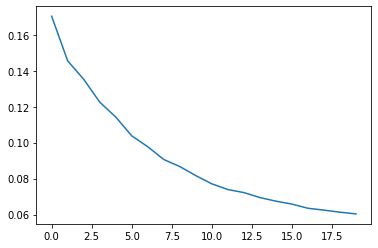

In [20]:
plt.plot(range(len(dist)),dist)
#area loss 0

In [92]:
mesh = Render.Scene("/root/workspace/data/bunny_vh_sub.ply")
closest, distance, triangle_id = closest_point(Target.mesh, mesh.mesh.vertices)
# closest, distance, triangle_id = closest_point(Target.mesh, kitten_vh.mesh.vertices)
cmap = plt.cm.get_cmap('jet')
# distance = distance*9.7*2
distance = distance*8.4
color = distance.copy()
max_dist = 0.4
# max_dist = 0.75
color[color>max_dist]=max_dist
mesh.mesh.visual.vertex_colors = cmap(color/max_dist)
# kitten_vh.mesh.visual.vertex_colors = cmap(color/max_dist)
distance.mean()

0.0855276903757315

In [87]:
_=mesh.mesh.export("/root/workspace/data/bunny_vh_sub.ply")


In [82]:
from trimesh.sample import sample_surface_even
sample,face_ind = sample_surface_even(kitten_vh.mesh, int(10e4))
closest, distance, triangle_id = closest_point(Target.mesh, sample)
distance = distance
distance.mean()

0.055422482702607155

In [73]:
v0 = kitten_vh.mesh.vertices[kitten_vh.mesh.faces[:,0]]
v1 = kitten_vh.mesh.vertices[kitten_vh.mesh.faces[:,1]]
v2 = kitten_vh.mesh.vertices[kitten_vh.mesh.faces[:,2]]
closest, distance0, triangle_id = closest_point(Target.mesh, v0)
closest, distance1, triangle_id = closest_point(Target.mesh, v1)
closest, distance2, triangle_id = closest_point(Target.mesh, v2)
distance = (distance0+distance1+distance2) / 3
(distance * kitten_vh.mesh.area_faces).sum() / kitten_vh.mesh.area_faces.sum() 

0.05385829797061216

In [74]:
kitten_vh.mesh.faces.shape

(12670, 3)

In [70]:
kitten_vh.mesh.area_faces.shape

(12670,)

In [34]:
kitten_vh.mesh.show()

TypeError: show() takes 1 positional argument but 3 were given

In [ ]:
kitten_vh.mesh.extents

In [7]:
# mesh = Render.Scene("/root/workspace/data/kitten_vh_sub.ply")
mesh = Render.Scene("/root/workspace/DR/bunny_optim_remesh.ply")
# point = mesh.mesh.vertices
# point[point[:,2]<-0.5, 2] =  -0.5
closest, distance, triangle_id = closest_point(Target.mesh, mesh.mesh.vertices)
cmap = plt.cm.get_cmap('jet')
# distance = distance*9.7*2
distance = distance*8.4*2
color = distance.copy()
# max_dist = 0.1
max_dist = distance.max()
color[color>max_dist]=max_dist
# mesh.mesh.visual.vertex_colors = cmap(color/max_dist)
distance.max()


0.5252967809628363

In [12]:
mask=mesh.mesh.vertices[:,1]>-0.48
distance[mask].mean()

0.02474191622427634

In [ ]:
mesh.mesh.show()

In [17]:
_=mesh.mesh.export("/root/workspace/DR/bunny_optim2.ply")